In [0]:
#import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import probplot
from scipy.stats.mstats import zscore
import statsmodels.stats.api as sms
import nltk
import collections as co

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import GridSearchCV

#from dask_ml.model_selection import GridSearchCV

%matplotlib inline
pd.set_option('max_columns', None)

In [0]:
!pip install -U -q imbalanced-learn

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials



In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#2. Get the file
downloaded = drive.CreateFile({'id':'1iZ6FE7L8uAXOIi92PT9sosHcUUA2m8Cs'})
downloaded.GetContentFile('loan.csv')  

In [0]:
#read loans.csv as a dataframe
loans_df = pd.read_csv('loan.csv',low_memory=False, engine='c')

In [10]:
loans_df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

In [11]:
loans_df['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


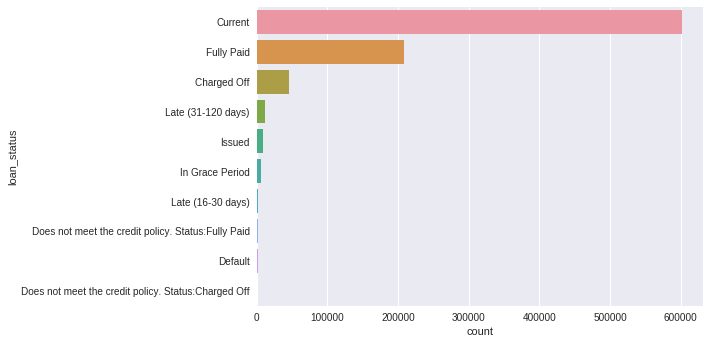

In [12]:
sns.set(style='darkgrid')
_=sns.countplot(y='loan_status', data=loans_df, order = loans_df['loan_status'].value_counts().index, orient='h')

In [0]:
#define a function to classify loan status into one of the following bins ('Fully Paid', 'Default', 'Current')
def loan_status_bin(text):
    if text in ('Fully Paid', 'Does not meet the credit policy. Status:Fully Paid'):
        return 'Fully Paid'
    elif text in ('Current', 'Issued'):
        return 'Current'
    elif text in ('Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off', 'Late (16-30 days)', 'Late (31-120 days)', 'In Grace Period'):
        return 'Default'
    else:
        'UNKNOWN BIN'

In [14]:
#create a new attribute 'loan_status_bin' in the dataframe
loans_df['loan_status_bin']=loans_df['loan_status'].apply(loan_status_bin)
loans_df['loan_status_bin'].unique()

array(['Fully Paid', 'Default', 'Current'], dtype=object)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


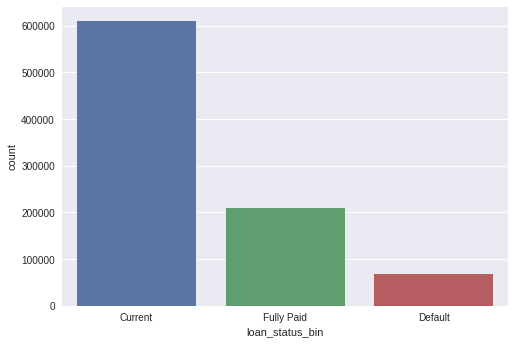

In [15]:
sns.set(style='darkgrid')
_=sns.countplot(x='loan_status_bin', data=loans_df, order = loans_df['loan_status_bin'].value_counts().index)

In [0]:
loans_df.fillna(loans_df.median()['annual_inc'], inplace=True)

In [17]:
loans_df[loans_df['annual_inc'].isnull()==True]['annual_inc'].count()

0

In [0]:
loans_df_fp=loans_df[loans_df['loan_status_bin']=='Fully Paid']

In [0]:
loans_df_def=loans_df[loans_df['loan_status_bin']=='Default']

In [20]:
print('For Default loans, mean annual income is {0}, standard deviation is {1}, size of dataframe is {2}'.format(loans_df_def['annual_inc'].mean(), loans_df_def['annual_inc'].std(), len(loans_df_def['annual_inc'])))

For Default loans, mean annual income is 67324.66868350415, standard deviation is 64812.91039063109, size of dataframe is 67429


In [21]:
print('For Fully Paid loans, mean annual income is {0}, standard deviation is {1}, size of dataframe is {2}'.format(loans_df_fp['annual_inc'].mean(), loans_df_fp['annual_inc'].std(), len(loans_df_fp['annual_inc'])))

For Fully Paid loans, mean annual income is 74142.5024192341, standard deviation is 59205.29202398379, size of dataframe is 209711


In [0]:
def_mean=loans_df_def['annual_inc'].mean()
def_std=loans_df_def['annual_inc'].std()

fp_mean=loans_df_fp['annual_inc'].mean()
fp_std=loans_df_fp['annual_inc'].std()

In [0]:
h0_mean = 0
mean_diff = abs(def_mean-fp_mean)
sigma_diff = np.sqrt((fp_std**2)/len(loans_df_fp) + (def_std**2)/len(loans_df_def))
mean_diff, sigma_diff

(8942.7356105612562, 292.23360521799054)

In [0]:
z = (mean_diff - h0_mean) / sigma_diff
z

30.601325278420518

In [0]:
p = (1-stats.norm.cdf(z))*2
p

0.0

In [0]:
#define a function to convert grade into numerical values
def credit_grade(grade):
    if grade in ('A'):
        return 1
    elif grade in ('B'):
        return 2
    elif grade in ('C'):
        return 3
    elif grade in ('D'):
        return 4
    elif grade in ('E'):
        return 5
    elif grade in ('F'):
        return 6
    elif grade in ('G'):
        return 7
    else:
        99

In [24]:
#create a new attribute 'loan_status_bin' in the dataframe
loans_df['credit_grade']=loans_df['grade'].apply(credit_grade)
loans_df['credit_grade'].unique()

array([2, 3, 1, 5, 6, 4, 7])

In [25]:
loans_df['application_type'].unique()

array(['INDIVIDUAL', 'JOINT'], dtype=object)

In [0]:
def derived_income(x, y, z):
    if x == 'INDIVIDUAL':
        return y
    elif x == 'JOINT':
        return z
    else:
        0

In [0]:
loans_df['derived_income']=loans_df.apply(lambda x: derived_income(x['application_type'], x['annual_inc'], x['annual_inc_joint']), axis=1)

In [0]:
def derived_dti(x, y, z):
    if x == 'INDIVIDUAL':
        return y
    elif x == 'JOINT':
        return z
    else:
        0

In [0]:
loans_df['derived_dti']=loans_df.apply(lambda x: derived_dti(x['application_type'], x['dti'], x['dti_joint']), axis=1)

In [0]:
loans_df['inst_inc_ratio']=loans_df['installment']/ (loans_df['derived_income'] /12)

## Model Training

Features: 
* loan_amount
* credit_grade 
* interest_rate 
* derived_inc
* derived_dti 
* inst_inc_ratio

### Training and Test Datasets

When fitting models, we would like to ensure two things:

* We have found the best model (in terms of model parameters).
* The model is highly likely to generalize i.e. perform well on unseen data.

<br/>
<div class="span5 alert alert-success">
<h4>Purpose of splitting data into Training/testing sets</h4>
<ul>
  <li> We built our model with the requirement that the model fit the data well. </li>
  <li> As a side-effect, the model will fit <b>THIS</b> dataset well. What about new data? </li>
    <ul>
      <li> We wanted the model for predictions, right?</li>
    </ul>
  <li> One simple solution, leave out some data (for <b>testing</b>) and <b>train</b> the model on the rest </li>
  <li> This also leads directly to the idea of cross-validation, next section. </li>  
</ul>
</div>

First, we try a basic Logistic Regression:

* Split the data into a training and test (hold-out) set
* Train on the training set, and test for accuracy on the testing set

In [0]:
loans_df_fp_def=loans_df[loans_df['loan_status_bin'].isin(['Fully Paid', 'Default'])]

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


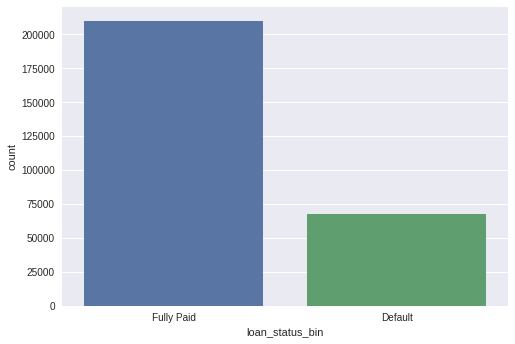

In [32]:
sns.set(style='darkgrid')
_=sns.countplot(x='loan_status_bin', data=loans_df_fp_def, order = loans_df_fp_def['loan_status_bin'].value_counts().index)

### Split the data into a training and test set.

In [0]:
X, y = loans_df_fp_def[['loan_amnt', 'credit_grade', 'int_rate', 'derived_income', 'derived_dti', 'inst_inc_ratio']].values, (loans_df_fp_def.loan_status_bin).values

In [0]:
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y, random_state=5)

In [0]:
loans_df_curr=loans_df[loans_df['loan_status_bin'].isin(['Current'])]

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


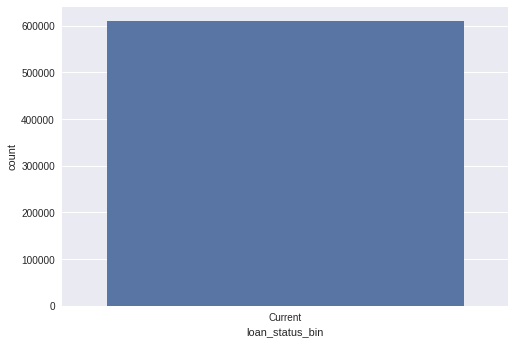

In [37]:
sns.set(style='darkgrid')
_=sns.countplot(x='loan_status_bin', data=loans_df_curr, order = loans_df_curr['loan_status_bin'].value_counts().index)

In [0]:
clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.754304683553


### Tuning the Model

The model has some hyperparameters we can tune for hopefully better performance. For tuning the parameters of your model, you will use a mix of *cross-validation* and *grid search*. In Logistic Regression, the most important parameter to tune is the *regularization parameter* `C`. Note that the regularization parameter is not always part of the logistic regression model. 

The regularization parameter is used to control for unlikely high regression coefficients, and in other cases can be used when data is sparse, as a method of feature selection.

You will now implement some code to perform model tuning and selecting the regularization parameter $C$.

We use the following `cv_score` function to perform K-fold cross-validation and apply a scoring function to each test fold. In this incarnation we use accuracy score as the default scoring function.


In [0]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

Below is an example of using the `cv_score` function for a basic logistic regression model without regularization.

In [0]:
clf1 = LogisticRegression()
score = cv_score(clf1, Xlr, ylr)
print(score)

0.757489596113


<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<b>Exercise:</b> Implement the following search procedure to find a good model
<ul>
<li> You are given a list of possible values of `C` below
<li> For each C:
  <ol>
  <li> Create a logistic regression model with that value of C
  <li> Find the average score for this model using the `cv_score` function **only on the training set** `(Xlr, ylr)`
  </ol>
<li> Pick the C with the highest average score
</ul>
Your goal is to find the best model parameters based *only* on the training set, without showing the model test set at all (which is why the test set is also called a *hold-out* set).
</div>

In [0]:
# your turn

#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]
max_score=0

for C in Cs:
    clf2 = LogisticRegression(C=C)
    score = cv_score(clf2, Xlr, ylr)
    if score > max_score:
        max_score = score
        best_C =C
print ('max_score: ',max_score, 'best_C: ', best_C)

max_score:  0.757489596113 best_C:  0.001


<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>
**Exercise:** Now you want to estimate how this model will predict on unseen data in the following way:
<ol>
<li> Use the C you obtained from the procedure earlier and train a Logistic Regression on the training data
<li> Calculate the accuracy on the test data
</ol>

<p>You may notice that this particular value of `C` may or may not do as well as simply running the default model on a random train-test split. </p>

<ul>
<li> Do you think that's a problem? 
<li> Why do we need to do this whole cross-validation and grid search stuff anyway?
</ul>

</div>

In [0]:
clf3=LogisticRegression(C=best_C)
clf3.fit(Xlr, ylr)
ypred=clf3.predict(Xtestlr)
print('accuracy score: ', accuracy_score(ypred, ytestlr), '\n')
print('I don\'t think there is a problem, since model accuracy has '
      'increased with addition of a regularization parameter')
print('We perform cross-validation and grid search to tune hyperparameters of our model')

accuracy score:  0.754304683553 

I don't think there is a problem, since model accuracy has increased with addition of a regularization parameter
We perform cross-validation and grid search to tune hyperparameters of our model


### Black Box Grid Search in `sklearn`

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<b>Exercise:</b> Use scikit-learn's [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) tool to perform cross validation and grid search. 

* Instead of writing your own loops above to iterate over the model parameters, can you use GridSearchCV to find the best model over the training set? 
* Does it give you the same best value of `C`?
* How does this model you've obtained perform on the test set?


In [0]:
# your turn
from sklearn.model_selection import GridSearchCV

clf4=LogisticRegression()
parameters = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
fitmodel = GridSearchCV(clf4, param_grid=parameters, cv=5, scoring="accuracy", return_train_score=True)
fitmodel.fit(Xlr, ylr)
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.cv_results_

clf5=LogisticRegression(C=fitmodel.best_params_['C'])
clf5.fit(Xlr, ylr)
ypred=clf5.predict(Xtestlr)

print('accuracy score: ', accuracy_score(ypred, ytestlr), '\n')
print('No, the new value of the C is: ', fitmodel.best_params_['C'], '\n')

accuracy score:  0.754304683553 

No, the new value of the C is:  0.0001 



In [0]:
# Decision Tree Classifier
from sklearn import datasets
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
# fit a CART model to the data
clf_dt = DecisionTreeClassifier()
clf_dt.fit(Xlr, ylr)
print(clf_dt)
# make predictions
ypred = clf_dt.predict(Xtestlr)
# summarize the fit of the model
print(metrics.classification_report(ytestlr, ypred))
print(metrics.confusion_matrix(ytestlr, ypred))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
             precision    recall  f1-score   support

    Default       0.31      0.32      0.32     17023
 Fully Paid       0.78      0.76      0.77     52262

avg / total       0.66      0.66      0.66     69285

[[ 5522 11501]
 [12314 39948]]


## Over Sampling using SMOTE

### Resampling using SMOTE

In [0]:
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

In [41]:
X_resampled, y_resampled = SMOTE().fit_sample(Xlr, ylr)
print(sorted(Counter(y_resampled).items()))

[('Default', 157449), ('Fully Paid', 157449)]


In [42]:
X_test_resampled, y_test_resampled = SMOTE().fit_sample(Xtestlr, ytestlr)
print(sorted(Counter(y_test_resampled).items()))

[('Default', 52262), ('Fully Paid', 52262)]


### Training a classifier (logistic regression) using SMOTE sampled data

In [0]:
clf_smote = LogisticRegression().fit(X_resampled, y_resampled)
print(clf_smote)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [0]:
# make predictions
ypred = clf_smote.predict(Xtestlr)
# summarize the fit of the model
print(metrics.classification_report(ytestlr, ypred))
print(metrics.confusion_matrix(ytestlr, ypred))

             precision    recall  f1-score   support

    Default       0.31      0.76      0.44     17023
 Fully Paid       0.85      0.45      0.59     52262

avg / total       0.72      0.53      0.55     69285

[[12972  4051]
 [28634 23628]]


In [0]:
print('accuracy score: ', accuracy_score(ypred, ytestlr), '\n')

accuracy score:  0.528252868586 



### Training Decision tree (CART) using SMOTE sampled data

In [0]:
# Decision Tree Classifier
from sklearn import datasets
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
# fit a CART model to the data
clf_dt_smote = DecisionTreeClassifier()
clf_dt_smote.fit(X_resampled, y_resampled)
print(clf_dt_smote)
# make predictions
ypred = clf_dt_smote.predict(Xtestlr)
# summarize the fit of the model
print(metrics.classification_report(ytestlr, ypred))
print(metrics.confusion_matrix(ytestlr, ypred))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
             precision    recall  f1-score   support

    Default       0.31      0.34      0.33     17023
 Fully Paid       0.78      0.75      0.77     52262

avg / total       0.66      0.65      0.66     69285

[[ 5872 11151]
 [12854 39408]]


### Predict loan status for loans with status = 'Current'

In [0]:
loans_df_curr['loan_status_pred']=clf_dt_smote.predict(loans_df_curr[['loan_amnt', 'credit_grade', 'int_rate', 'derived_income', 'derived_dti', 'inst_inc_ratio']])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


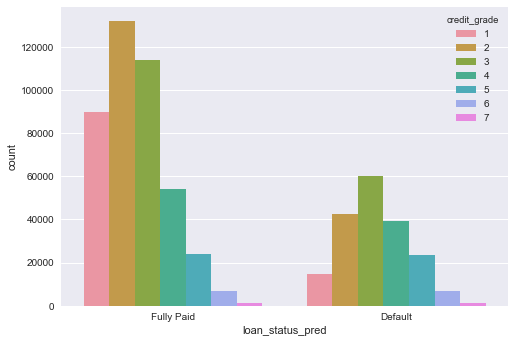

In [0]:
sns.set(style='darkgrid')
_=sns.countplot(x='loan_status_pred', data=loans_df_curr, order = loans_df_curr['loan_status_pred'].value_counts().index, hue='credit_grade')

### Hyper parameter tuning of Decision Tree

In [0]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]

In [0]:
n_estimators

[200, 650, 1100, 1550, 2000]

## Training Random forest using SMOTE sampled data

In [0]:

clf_rf_1 = RandomForestClassifier(max_depth=5, random_state=0)

In [0]:
clf_rf_1.fit(X_resampled, y_resampled)
print(clf_rf_1.feature_importances_)

[ 0.02463866  0.52023963  0.36261194  0.01070639  0.06651044  0.01529294]


In [0]:
print(clf_rf_1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


In [0]:
# make predictions
ypred = clf_rf_1.predict(Xtestlr)
# summarize the fit of the model
print(metrics.classification_report(ytestlr, ypred))
print(metrics.confusion_matrix(ytestlr, ypred))

### Hyperparameter tuning for Random Forest - II

#### Randomized Search CV

In [0]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [0]:
print(random_grid)

{'n_estimators': [200, 650, 1100, 1550, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 32, 55, 77, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [0]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
clf_rf_2 = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = clf_rf_2, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=77, bootstrap=False 
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=77, bootstrap=False 
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=77, bootstrap=False 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=77, bootstrap=False, total= 6.5min
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=77, bootstrap=False, total= 7.1min
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=None, boots

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 360.4min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [200, 650, 1100, 1550, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 32, 55, 77, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=2)

In [0]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=55, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
rf_random.cv_results_

{'mean_fit_time': array([  383.12628023,  5140.30518508,  1132.78761164,  1436.26093531,
          528.25576274,   914.40572794,  1276.98479168,   279.51547917,
         5309.87085724,  2701.06569139]),
 'mean_score_time': array([   30.56938227,  1093.70888766,   138.91831342,   716.05484041,
           15.2453169 ,    30.58743819,   146.24274071,    15.88703672,
         1700.91918516,   522.30573805]),
 'mean_test_score': array([ 0.77174196,  0.77273276,  0.76145609,  0.76807411,  0.76715952,
         0.73779764,  0.7719325 ,  0.76102103,  0.77295505,  0.76394261]),
 'mean_train_score': array([ 0.99983804,  0.9998571 ,  0.94190976,  0.98733082,  0.98658296,
         0.76829323,  0.99957764,  0.93498847,  0.99996189,  0.95725918]),
 'param_bootstrap': masked_array(data = [False False True True True True False True False True],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'param_max_depth': masked_array(data = [77 None 32

#### Grid Search CV

In [0]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [45, 55, 65, 70],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [1900, 2000, 2100]
}

# Create a base model
rf = RandomForestClassifier(random_state = 42)

In [44]:
print(param_grid)

{'bootstrap': [False], 'max_depth': [45, 55, 65, 70], 'max_features': ['sqrt'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 3, 4], 'n_estimators': [1900, 2000, 2100]}


In [0]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, return_train_score=True, verbose=4)

In [0]:
# Fit the grid search to the data
grid_search.fit(X_resampled, y_resampled)

### Trying Calssification with Scaling

In [0]:
# Import the necessary modules
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('rfc', RandomForestClassifier())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42)

# Fit the pipeline to the training set: knn_scaled
knn_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
knn_unscaled = RandomForestClassifier().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(knn_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(knn_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.7129008202833707
Accuracy without Scaling: 0.7138510019003632


### Gradient Boosting using XGBoost

In [0]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

In [48]:
model = XGBClassifier()
model.fit(X_resampled, y_resampled)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [49]:
# make predictions for test data
# Xtestlr, ytestlr
y_pred = model.predict(Xtestlr)
# evaluate predictions
accuracy = accuracy_score(ytestlr, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 73.41%


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [50]:
model.feature_importances_

array([0.06033183, 0.50980395, 0.20361991, 0.05580694, 0.10105581,
       0.0693816 ], dtype=float32)

In [53]:
# fit model on training data
xgb = XGBClassifier()
eval_set = [(Xtestlr, ytestlr)]
xgb.fit(X_resampled, y_resampled, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)


[0]	validation_0-logloss:0.674542
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.65959
[2]	validation_0-logloss:0.647495
[3]	validation_0-logloss:0.637671
[4]	validation_0-logloss:0.629663
[5]	validation_0-logloss:0.623125
[6]	validation_0-logloss:0.617781
[7]	validation_0-logloss:0.613406
[8]	validation_0-logloss:0.609829
[9]	validation_0-logloss:0.606323
[10]	validation_0-logloss:0.603409
[11]	validation_0-logloss:0.601319
[12]	validation_0-logloss:0.599124
[13]	validation_0-logloss:0.597224
[14]	validation_0-logloss:0.591411
[15]	validation_0-logloss:0.589108
[16]	validation_0-logloss:0.587543
[17]	validation_0-logloss:0.585386
[18]	validation_0-logloss:0.58196
[19]	validation_0-logloss:0.580544
[20]	validation_0-logloss:0.57676
[21]	validation_0-logloss:0.575418
[22]	validation_0-logloss:0.574052
[23]	validation_0-logloss:0.572041
[24]	validation_0-logloss:0.571154
[25]	validation_0-logloss:0.570345
[26]	validation_0-logloss:0.569564


[73]	validation_0-logloss:0.545115
[74]	validation_0-logloss:0.544692
[75]	validation_0-logloss:0.544508
[76]	validation_0-logloss:0.544118
[77]	validation_0-logloss:0.54399
[78]	validation_0-logloss:0.543368
[79]	validation_0-logloss:0.543235
[80]	validation_0-logloss:0.543124
[81]	validation_0-logloss:0.543105
[82]	validation_0-logloss:0.54278
[83]	validation_0-logloss:0.542728
[84]	validation_0-logloss:0.542664
[85]	validation_0-logloss:0.54256
[86]	validation_0-logloss:0.542174
[87]	validation_0-logloss:0.541896
[88]	validation_0-logloss:0.541919
[89]	validation_0-logloss:0.541856
[90]	validation_0-logloss:0.541816
[91]	validation_0-logloss:0.541718
[92]	validation_0-logloss:0.541689
[93]	validation_0-logloss:0.541419
[94]	validation_0-logloss:0.541108
[95]	validation_0-logloss:0.541046
[96]	validation_0-logloss:0.540947
[97]	validation_0-logloss:0.540922
[98]	validation_0-logloss:0.540699
[99]	validation_0-logloss:0.540655


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [54]:
# make predictions for test data
y_pred = xgb.predict(Xtestlr)
# evaluate predictions
accuracy = accuracy_score(ytestlr, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 73.41%


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [0]:
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

In [0]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(xgb, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold,
verbose=1)
result = grid_search.fit(X_resampled, y_resampled)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.2min


In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))